**1. 경고 메세지 숨기기**

In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

**2. 데이터 불러오기**

In [2]:
import pandas as pd 
origin_2017 = pd.read_csv('./data/stock_origin_2017.csv')
origin_2018 = pd.read_csv('./data/stock_origin_2018.csv')
origin_2019 = pd.read_csv('./data/stock_origin_2019.csv')
new_2017 = pd.read_csv('./data/stock_new_2017.csv')
new_2018 = pd.read_csv('./data/stock_new_2018.csv')
new_2019 = pd.read_csv('./data/stock_new_2019.csv')

**3. 불필요한 열 제거**

In [3]:
origin_2017 = origin_2017.iloc[:,2:]
origin_2018 = origin_2018.iloc[:,2:]
origin_2019 = origin_2019.iloc[:,2:]
new_2017 = new_2017.iloc[:,2:]
new_2018 = new_2018.iloc[:,2:]
new_2019 = new_2019.iloc[:,2:]

**4. 각각의 데이터셋의 크기**

In [4]:
print('{}\'s size is {:,} obs' .format('origin_2017', len(origin_2017)))
print('{}\'s size is {:,} obs' .format('origin_2018', len(origin_2018)))
print('{}\'s size is {:,} obs' .format('origin_2019', len(origin_2019)), end='\n\n')
print('{}\'s size is {:,} obs' .format('new_2017', len(new_2017)))
print('{}\'s size is {:,} obs' .format('new_2018', len(new_2018)))
print('{}\'s size is {:,} obs' .format('new_2019', len(new_2019)))

origin_2017's size is 587,165 obs
origin_2018's size is 643,886 obs
origin_2019's size is 702,204 obs

new_2017's size is 587,165 obs
new_2018's size is 643,886 obs
new_2019's size is 702,204 obs


**5. Origin과 New Merge하기**

In [5]:
data_2017 = pd.merge(origin_2017, new_2017).set_index('date')
data_2018 = pd.merge(origin_2018, new_2018).set_index('date')
data_2019 = pd.merge(origin_2019, new_2019).set_index('date')

**6. 거래 정지 종목 제거**

In [6]:
data_2017 = data_2017[data_2017['trading_volume'] != 0]
data_2018 = data_2018[data_2018['trading_volume'] != 0]
data_2019 = data_2019[data_2019['trading_volume'] != 0]

**7. Test 종목**

In [7]:
test_code = '000660'

**8. 학습, 테스트셋 생성**

In [8]:
data = pd.concat([data_2017[data_2017['code']==test_code],data_2018[data_2018['code']==test_code],
                  data_2019[data_2019['code']==test_code]])

In [9]:
train = data['2017-01-01':'2018-12-31']
test = data['2019-01-01':]

**9. DATA 쉬프트**

In [10]:
train['Target'] = train['close'].shift(-1)
test['Target'] = test['close'].shift(-1)

In [11]:
train = train.dropna()
test = test.dropna()

**10. 종속변수, 독립변수 지정**

In [12]:
X_train = train[['open','high','low','trading_volume','trading_value','kindex','index','score','probability']]
y_train = train[['Target']]
X_test = test[['open','high','low','trading_volume','trading_value','kindex','index','score','probability']]
y_test = test[['Target']]

**11. LightGBM**

In [15]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test) 

In [16]:
params = {'learning_rate': 0.1, 
          'max_depth': 5, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2020}

In [17]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.50836e+06
Early stopping, best iteration is:
[49]	valid_0's l2: 4.32385e+06


**12. RMSE**

In [18]:
from sklearn.metrics import mean_squared_error
y_true = y_test
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_true, y_pred)**0.5
print("{}'s rmse is {:.2f}" .format(test_code,rmse))

000660's rmse is 2079.39


**14. Visualization**

In [19]:
y_pred = pd.DataFrame({'y_pred':y_pred.reshape(-1)}, index=test.index)
result = pd.concat([y_pred, y_test], axis=1)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,6))
ax = sns.lineplot(data=result, palette="tab10", linewidth=2.5)
ax.set(xticks = result.index[0::30])
plt.show()

<Figure size 1800x600 with 1 Axes>

**15. UP and Down**

In [21]:
# Actual
result['Traget_shift'] = result['Target'].shift(-1)
result['TRUE_UP_DOWN'] = result['Traget_shift'] - result['Target']
result['TRUE_UP_DOWN'] = result['TRUE_UP_DOWN'].apply(lambda x : 1 if x > 0 else -1)

# Pred
result['Pred_shift'] = result['y_pred'].shift(-1)
result['PRED_UP_DOWN'] = result['Pred_shift'] - result['Target']
result['PRED_UP_DOWN'] = result['PRED_UP_DOWN'].apply(lambda x : 1 if x > 0 else -1)

# O,X
result['OX'] = result['TRUE_UP_DOWN'] - result['PRED_UP_DOWN']
result['OX'] = result['OX'].apply(lambda x : 1 if x == 0 else -1)

# Result
result[['y_pred', 'Target', 'TRUE_UP_DOWN', 'PRED_UP_DOWN', 'OX']]

,y_pred,Target,TRUE_UP_DOWN,PRED_UP_DOWN,OX
date,,,,,
2019-01-02,61591.459318,57700.0,1,1,1
2019-01-03,60726.446666,58300.0,1,-1,-1
2019-01-04,56998.777325,58700.0,1,1,1
2019-01-07,59215.636972,59200.0,1,-1,-1
2019-01-08,59154.071021,63600.0,1,-1,-1
...,...,...,...,...,...
2019-12-20,91609.861765,94600.0,-1,-1,1
2019-12-23,90731.763598,93800.0,1,-1,-1
2019-12-24,90731.763598,94800.0,1,-1,-1


**16. UP and Down Visualization**

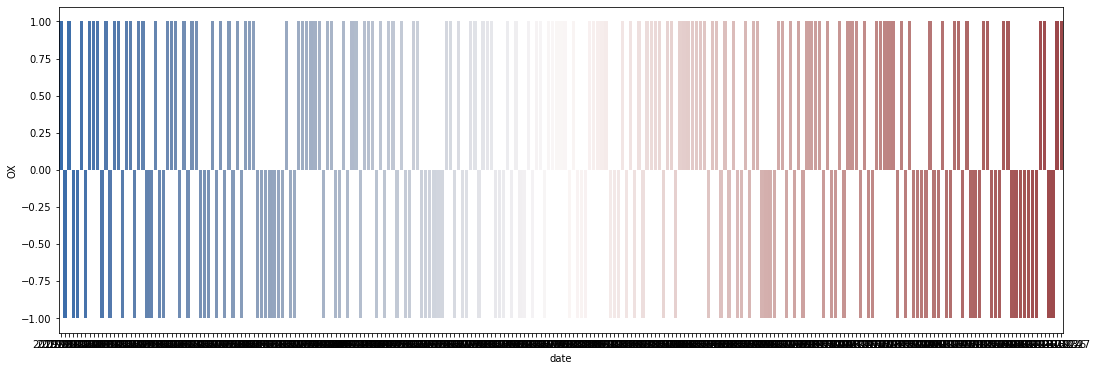

In [22]:
plt.figure(figsize=(18,6))
sns.barplot(x=result.index, y=result['OX'], palette="vlag")
plt.show()

**17. Confusuion Matrix**

In [23]:
from sklearn.metrics import confusion_matrix
print('=== Confusion Matrix ===')
cf = confusion_matrix(result['TRUE_UP_DOWN'], result['PRED_UP_DOWN'])
print(cf)
print('Test Acc = {:.4f}' .format((cf[0,0] + cf[1,1]) / (cf[0,0] + cf[0,1] + cf[1,0] + cf[1,1])))
print('Test Adj Acc = {:.4f}' .format(((cf[0,0]+cf[1,1])-(cf[1,0]+cf[1,1]))/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])))

=== Confusion Matrix ===
[[68 50]
 [66 61]]
Test Acc = 0.5265
Test Adj Acc = 0.0082
